Epoch 1/20
8/8 [==============================] - 1s 19ms/step - loss: 20.1189 - val_loss: 26.9908
Epoch 2/20
8/8 [==============================] - 0s 6ms/step - loss: 16.2513 - val_loss: 24.7734
Epoch 3/20
8/8 [==============================] - 0s 6ms/step - loss: 14.7605 - val_loss: 23.0483
Epoch 4/20
8/8 [==============================] - 0s 6ms/step - loss: 13.7757 - val_loss: 21.3519
Epoch 5/20
8/8 [==============================] - 0s 5ms/step - loss: 12.2120 - val_loss: 20.1465
Epoch 6/20
8/8 [==============================] - 0s 6ms/step - loss: 11.8193 - val_loss: 18.9935
Epoch 7/20
8/8 [==============================] - 0s 6ms/step - loss: 10.9027 - val_loss: 18.3391
Epoch 8/20
8/8 [==============================] - 0s 6ms/step - loss: 10.6273 - val_loss: 17.2690
Epoch 9/20
8/8 [==============================] - 0s 5ms/step - loss: 10.5629 - val_loss: 15.4217
Epoch 10/20
8/8 [==============================] - 0s 5ms/step - loss: 9.5092 - val_loss: 13.8179
Epoch 11/20
8/8 [==

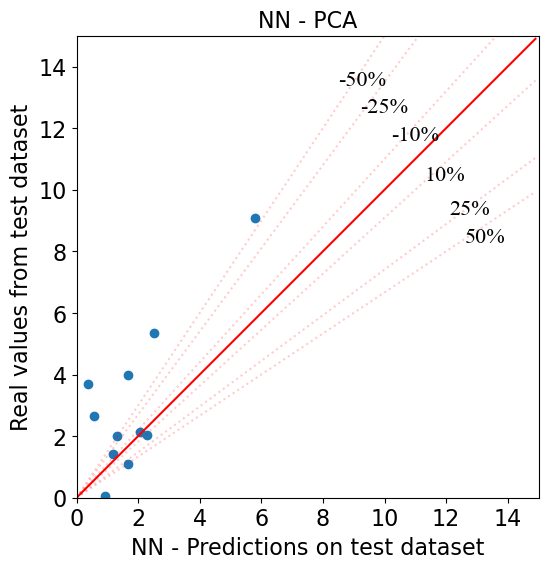

In [3]:
### This script shows the code used for data preparation and training of a ML algorithm as described in the manuscript 
### "Porosity prediction of cold sprayed titanium parts using machine learning".

#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
import random as rd

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow import keras
from keras.models import Model


#Load the data

data= pd.read_excel('Synthetic_data_CS_porosity.xlsx')

# Chapter 3.3 "Data preparation with stratified sampling techniques")
##Prepare data for startified sampling - Create bins

bins = [0, 1, 2, 3, 4, float('inf')]

## Bin the "Porosity" column
data['Bins'] = pd.cut(data['Porosity'], bins=bins, include_lowest=True, labels=False)

## Apply One hot encoding to categorical parameters in the dataset

data = pd.get_dummies(data, prefix_sep="__", columns=['Spray type'])
data = pd.get_dummies(data, prefix_sep="__", columns=['Powder morphology'])
data = pd.get_dummies(data, prefix_sep="__", columns=['Cold spray system'])

## Split into training and testing data
split = StratifiedShuffleSplit (n_splits=1, test_size = 0.2, random_state =42)
for train_index, test_index in split.split(data,data['Bins']):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
input_parameters = [col for col in data.columns if col not in ['Porosity', 'Bin']]
target_parameter =['Porosity']

X_train = strat_train_set[input_parameters]
y_train = strat_train_set[target_parameter]
X_test = strat_test_set[input_parameters]
y_test = strat_test_set[target_parameter]

## Application of Standardscaler to centre and scale the data 

X_train2 = X_train.drop(columns=['Spray type__rotatory', 'Powder morphology__irregular','Cold spray system__TKF_1000'])
X_test2 = X_test.drop(columns=['Spray type__rotatory', 'Powder morphology__irregular','Cold spray system__TKF_1000'])

scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(X_train2)
scaled_x_test=scaler.fit_transform(X_test2)

# Chapter 4.1 Algorithm implementation with hyperparameter optimisation

## Data Transformation Using Principal Component Analysis (PCA)
### The process of selecting the optimal number of principal components is not shown here.
### In this analysis, the number of optimal components is set to 5, which was determined to be 
### the most effective number for training the models described in the manuscript.

pca =PCA(n_components=5)
pca.fit(scaled_x_train)
pca_x_train = pca.transform(scaled_x_train)
pca_x_test = pca.transform(scaled_x_test)

## Training of Neural Network model with optimal hyperparameters
### The process of selecting the optimal number of hyperparameters is not shown here
n_neurons = 85
n_hidden = 2
learning_rate = 0.001
activation = 'tanh'
optimizer = 'Adam'
batch_size = 5
epochs = 20
random_seed =10

### Data Splitting and Column Extraction for Training and Validation Sets
x_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(pca_x_train, y_train, test_size=0.2, random_state=42)
column_array1 = y_train_nn['Porosity'].values.reshape(-1, 1)
column_array2 = y_val_nn['Porosity'].values.reshape(-1, 1)
y_train_nn = column_array1
y_val_nn=column_array2

### Definition of Neural Network
def build_model(n_hidden, n_neurons,random_seed, learning_rate, activation, optimizer):
    tf.random.set_seed(random_seed)
    use_batchnorm=True
    inputs = keras.Input(shape=x_train_nn.shape[1:])
    hidden_layers = []
    for layer in range(n_hidden):
        if layer == 0:
            hidden_layers.append(keras.layers.Dense(n_neurons)(inputs))
        else:
            if activation == "sigmoid" or activation == "tanh":
                initializer = 'he_normal'
            elif activation == "relu":
                initializer = 'glorot_uniform'
            dense_layer = keras.layers.Dense(n_neurons, kernel_initializer=initializer)(hidden_layers[layer-1])
            if use_batchnorm:
                dense_layer = BatchNormalization()(dense_layer)
            hidden_layers.append(dense_layer)
        if activation == "sigmoid":
            hidden_layers.append(keras.layers.Activation('sigmoid')(hidden_layers[-1]))
        elif activation == "tanh":
            hidden_layers.append(keras.layers.Activation('tanh')(hidden_layers[-1]))
        elif activation == "relu":
            hidden_layers.append(keras.layers.Activation('relu')(hidden_layers[-1]))
    outputs = keras.layers.Dense(1)(hidden_layers[-1])
    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = getattr(keras.optimizers, optimizer)(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

### Training of Neural Network
model = build_model(n_hidden=n_hidden, n_neurons=n_neurons,random_seed=random_seed,
                    learning_rate=learning_rate, activation=activation, optimizer=optimizer)
history = model.fit(x_train_nn, y_train_nn, epochs=epochs, batch_size=batch_size, validation_data=(X_val_nn, y_val_nn))

# Chapter 4.2 Model performance evaluation
## Show the predictions of the NN model on the test set
pred_test = model.predict(pca_x_test)
pred_test_list=pred_test.tolist()
pred_test_list = [item for sublist in pred_test_list for item in sublist]

### create plot (predict vs. real)
#### predicted value 100 % smaller than real value
a = 10
b = 5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle = math.degrees(result)

#### predicted value 50 % smaller than real value
a = 7.5
b = 5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_50_smaller = math.degrees(result)

#### predicted value 50 % bigger than real value
a = 5
b = 7.5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_50_bigger = math.degrees(result)

#### predicted value 25 % smaller than real value
a = 6.75
b = 5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_25_smaller = math.degrees(result)

#### predicted value 25 % bigger than real value
a = 5
b = 6.75
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_25_bigger = math.degrees(result)

#### predicted value 10 % smaller than real value
a = 5.5
b = 5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_10_smaller = math.degrees(result)

#### predicted value 10 % bigger than real value
a = 5
b = 5.5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_10_bigger = math.degrees(result)

#### predicted value 5 % smaller than real value
a = 5.25
b = 5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_5_smaller = math.degrees(result)

#### predicted value 5 % bigger than real value
a = 5
b = 5.25
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_5_bigger = math.degrees(result)

fig = plt.figure(figsize=(6, 6))
plt.scatter(pred_test_list, y_test)

xmin, xmax = plt.xlim(0,15)
ymin, ymax = plt.ylim(0,15)
xmin_ymin = min(xmin, ymin)
xmax_ymax = max(xmax, ymax)
line_coords = np.arange(xmin_ymin, xmax_ymax, 0.1)
plt.plot(line_coords, line_coords, color='red')

angle_deg = angle_50_smaller
angle_rad = np.radians(angle_deg)
y_coords = line_coords * np.tan(angle_rad)
plt.plot(line_coords, y_coords, color='red', linestyle='dotted', alpha=0.2)
plt.annotate('-50%', xy=(8.5, 13.4), color='black', fontsize=16, fontname='Times New Roman')

angle_deg = angle_50_bigger
angle_rad = np.radians(angle_deg)
y_coords = line_coords * np.tan(angle_rad)
plt.plot(line_coords, y_coords, color='red', linestyle='dotted', alpha=0.2)
plt.annotate('50%', xy=(12.6, 8.3), color='black', fontsize=16, fontname='Times New Roman')

angle_deg = angle_25_smaller
angle_rad = np.radians(angle_deg)
y_coords = line_coords * np.tan(angle_rad)
plt.plot(line_coords, y_coords, color='red', linestyle='dotted', alpha=0.2)
plt.annotate('-25%', xy=(9.2, 12.5), color='black', fontsize=16, fontname='Times New Roman')

angle_deg = angle_25_bigger
angle_rad = np.radians(angle_deg)
y_coords = line_coords * np.tan(angle_rad)
plt.plot(line_coords, y_coords, color='red', linestyle='dotted', alpha=0.2)
plt.annotate('25%', xy=(12.1, 9.2), color='black', fontsize=16, fontname='Times New Roman')

angle_deg = angle_10_smaller
angle_rad = np.radians(angle_deg)
y_coords = line_coords * np.tan(angle_rad)
plt.plot(line_coords, y_coords, color='red', linestyle='dotted', alpha=0.2)
plt.annotate('-10%', xy=(10.2, 11.6), color='black', fontsize=16, fontname='Times New Roman')

angle_deg = angle_10_bigger
angle_rad = np.radians(angle_deg)
y_coords = line_coords * np.tan(angle_rad)
plt.plot(line_coords, y_coords, color='red', linestyle='dotted', alpha=0.2)
plt.annotate('10%', xy=(11.3, 10.3), color='black', fontsize=16, fontname='Times New Roman')

plt.xlabel('NN - Predictions on test dataset',fontsize=16)
plt.ylabel('Real values from test dataset',fontsize=16)
plt.title('NN - PCA',fontsize=16)
plt.gca().set_aspect('equal')
ticks = np.linspace(0, 15, 5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()